In [2]:
options(warn=-1)
library(openxlsx)
library(tidyverse)
library(reshape)

library(ggplot2)
library(ggpubr)
library(RColorBrewer)
library(corrplot)
library(corrr)

library(DescTools) #Fisher Z
library(rstatix)

# Predict models

In [3]:
regions_order = c(
    # English
    'USA','UK','Australia','South Africa',
    # Germany
    'Germany',
    # Japanese
    'Japan',
    # Hebrew
    'Israel',
    # Chinese
    'CHN','HK(region)',

    # French
    'France',
    # Spanish
    'Spain','Mexico','Chile',
    # Portuguese
    'Portugal','Brazil',
    # Russian
    'Russia',
    # Arabic
    'Egypt','Qatar',
    'India')

fix_region = function(df){
    regions = rownames(df)
    regions = str_replace(regions,'United States','USA')
    regions = str_replace(regions,'United Kingdom','UK')
    regions = str_replace(regions,'China','CHN')
    regions = str_replace(regions,'South_africa','South Africa')
    regions = str_replace(regions,'Spain','Spanish')
    regions = str_replace(regions,'HK','HK(region)')
    regions = gsub('Hong Kong SAR, CHN','HK(region)',regions,fixed=TRUE)
    regions = str_replace(regions,'Hong Kong','HK(region)')
    regions = str_replace(regions,'Spanish','Spain')
    regions = str_replace(regions,'Russian Federation','Russia')
    regions = str_replace(regions,'Russian','Russia')
    regions = str_replace(regions,'Egypt, Arab Rep.','Egypt')
    
    rownames(df) = regions
    colnames(df) = regions
    
    df = df[regions_order,regions_order]
    return(df)
}

lowerTriangle <- function(m){
  return(m[lower.tri(m,diag = FALSE)])
}

In [4]:
# check size
check_size = read.csv('../DataCleanPCA/output_data/rdm/check_size_rdm.csv', row.names=1, encoding = "UTF-8",check.names = FALSE)
check_size = fix_region(check_size)

In [5]:
# get rdms of predicators 
variables_names <- c('check_size')

variables <- list()
for(i in c(1:length(variables_names))){
  variables[[i]] = get(variables_names[i])
}

In [6]:
permutation_result = function(culture_regress_standard_model){
    # create permutation matrix
    nperm <- 10000
    permf <- matrix(NA,nperm)
    permr2 <- matrix(NA,nperm)
    # contain beta
    permt <- matrix(NA,nperm,length(variables_names)) # 12variables
    colnames(permt) <- variables_names
    # caculate proportation of beta or F value over the model results
    permf_pvals <- NA 
    permt_pvals <- NA
    tstats = NA

    # the model results
    fstats <- culture_regress_standard_model$fstatistic[[1]]
    for (i in 1:length(variables_names)){
      tstats[i] <- culture_regress_standard_model$coefficients[1+i,1]
    }
    r2stats <- culture_regress_standard_model$r.squared
    print(paste('fstats:',fstats))
    #print('tstats:')
    #tstats
    print(paste('r2stats:',r2stats))

    set.seed(2)
    for (i in 1:nperm){
      psel <- sample(19) # permuted index, total 19 regions
      x <- do.call(cbind,lapply(variables,function(x) lowerTriangle(x[psel,psel]))) # generate permuted predictors
      rfit <- lm(scale(model_rdm_array)~scale(x)) # fit permuted model
      srfit <- summary(rfit)
      permf[i,1] <- srfit$fstatistic[1] # F-stat
      permr2[i,1] <- srfit$r.squared # R-squared
      #permf[,i] <- unlist(lapply(srfit,function(x) x$fstatistic[1])) # F-stat
      #permr2[,i] <- unlist(lapply(srfit,function(x) x$r.squared)) # R-squared
      for (j in 1:length(variables_names)){
        permt[i,j] <- srfit$coefficients[1+j,1] # each var t-stat
      }
      #print(i)
    }
    print(i)

    # F statistics
    permf_pvals <- mean(permf[,1] >= fstats)
    print(paste('permf_pvals',permf_pvals))

    # Each variable's regression
    for (i in 1:length(variables_names)){
      permt_pvals[i] <- mean(permt[,i] >= tstats[i])
    }

    permt_pvals <- as.data.frame(t(permt_pvals)) 

    colnames(permt_pvals) <- variables_names
    return(permt_pvals)
} 

## Full feature model

In [7]:
# regression coefficient
model_rdm = read.csv('output_data/models_rdm/full_feature/raw33d_dissim_dist.csv',
                    row.names =1, check.names = FALSE)
model_rdm = model_rdm[regions_order,regions_order]
model_rdm_array = lowerTriangle(model_rdm)

x <- do.call(cbind,lapply(variables,function(x) lowerTriangle(x))) # generate permuted predictors
colnames(x) = variables_names
culture_regress_standard <- lm(scale(model_rdm_array)~scale(x))
culture_regress_standard_model <- summary(culture_regress_standard)
culture_regress_standard_model

full_feature_regression = culture_regress_standard_model
                          
# permutation
p_value = permutation_result(full_feature_regression)
p_value


Call:
lm(formula = scale(model_rdm_array) ~ scale(x))

Residuals:
    Min      1Q  Median      3Q     Max 
-1.7256 -0.8372 -0.2882  0.8037  2.4367 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) 1.865e-16  7.663e-02   0.000    1.000
scale(x)    4.178e-02  7.686e-02   0.544    0.587

Residual standard error: 1.002 on 169 degrees of freedom
Multiple R-squared:  0.001745,	Adjusted R-squared:  -0.004161 
F-statistic: 0.2955 on 1 and 169 DF,  p-value: 0.5874


[1] "fstats: 0.295492358528796"
[1] "r2stats: 0.00174542366375007"
[1] 10000
[1] "permf_pvals 0.8137"


check_size
<dbl>
0.3843


## Dimensional model

In [8]:
# regression coefficient
model_rdm = read.csv('output_data/models_rdm/dimensional/favee_dissim_dist.csv',
                    row.names =1, check.names = FALSE)
model_rdm = model_rdm[regions_order,regions_order]
model_rdm_array = lowerTriangle(model_rdm)

x <- do.call(cbind,lapply(variables,function(x) lowerTriangle(x))) # generate permuted predictors
colnames(x) = variables_names
culture_regress_standard <- lm(scale(model_rdm_array)~scale(x))
culture_regress_standard_model <- summary(culture_regress_standard)
culture_regress_standard_model

dimensional_regression = culture_regress_standard_model
                          
# permutation
p_value = permutation_result(dimensional_regression)
p_value


Call:
lm(formula = scale(model_rdm_array) ~ scale(x))

Residuals:
    Min      1Q  Median      3Q     Max 
-1.6618 -0.9381 -0.1540  0.9462  2.1233 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) 3.368e-17  7.664e-02   0.000    1.000
scale(x)    3.915e-02  7.686e-02   0.509    0.611

Residual standard error: 1.002 on 169 degrees of freedom
Multiple R-squared:  0.001532,	Adjusted R-squared:  -0.004376 
F-statistic: 0.2594 on 1 and 169 DF,  p-value: 0.6112


[1] "fstats: 0.259377160407767"
[1] "r2stats: 0.00153242416910204"
[1] 10000
[1] "permf_pvals 0.8146"


check_size
<dbl>
0.3905


## Categorical model

In [9]:
# regression coefficient
model_rdm = read.csv('output_data/models_rdm/categorical/hpp_dissim_dist.csv',
                    row.names =1, check.names = FALSE)
model_rdm = model_rdm[regions_order,regions_order]
model_rdm_array = lowerTriangle(model_rdm)

x <- do.call(cbind,lapply(variables,function(x) lowerTriangle(x))) # generate permuted predictors
colnames(x) = variables_names
culture_regress_standard <- lm(scale(model_rdm_array)~scale(x))
culture_regress_standard_model <- summary(culture_regress_standard)
culture_regress_standard_model

categorical_regression = culture_regress_standard_model

# permutation
p_value = permutation_result(categorical_regression)
p_value


Call:
lm(formula = scale(model_rdm_array) ~ scale(x))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.28780 -0.72477  0.04801  0.68434  2.44150 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)
(Intercept)  1.873e-16  7.650e-02   0.000    1.000
scale(x)    -7.155e-02  7.673e-02  -0.933    0.352

Residual standard error: 1 on 169 degrees of freedom
Multiple R-squared:  0.00512,	Adjusted R-squared:  -0.000767 
F-statistic: 0.8697 on 1 and 169 DF,  p-value: 0.3524


[1] "fstats: 0.869713672561364"
[1] "r2stats: 0.00511988661049852"
[1] 10000
[1] "permf_pvals 0.6268"


check_size
<dbl>
0.6685


# Regressed onto cultural variables

In [10]:
# Language
Lexical = read.csv('../Cultural_RDM/rdm/Lexical_dist.csv', row.names=1, encoding = "UTF-8",check.names = FALSE)
Lexical = fix_region(Lexical)

# Personality
Agreeableness = read.csv('../Cultural_RDM/rdm/Agreeableness_dist.csv',row.names=1, encoding = "UTF-8",check.names = FALSE)
Agreeableness = fix_region(Agreeableness)
Conscientiousness = read.csv('../Cultural_RDM/rdm/Conscientiousness_dist.csv',row.names=1, encoding = "UTF-8",check.names = FALSE)
Conscientiousness = fix_region(Conscientiousness)
Extraversion = read.csv('../Cultural_RDM/rdm/Extraversion_dist.csv',row.names=1, encoding = "UTF-8",check.names = FALSE)
Extraversion = fix_region(Extraversion)
Neuroticism = read.csv('../Cultural_RDM/rdm/Neuroticism_dist.csv',row.names=1, encoding = "UTF-8",check.names = FALSE)
Neuroticism = fix_region(Neuroticism)
Openness = read.csv('../Cultural_RDM/rdm/Openness_dist.csv',row.names=1, encoding = "UTF-8",check.names = FALSE)
Openness = fix_region(Openness)
personality_all = read.csv('../Cultural_RDM/rdm/personality_all_dist.csv', row.names=1, encoding = "UTF-8",check.names = FALSE)
personality_all = fix_region(personality_all)

# Socioecological
Climatic_demands = read.csv('../Cultural_RDM/rdm/Climatic_demands_dist.csv', row.names=1, encoding = "UTF-8",check.names = FALSE)
Climatic_demands = fix_region(Climatic_demands)
Coordinate = read.csv('../Cultural_RDM/rdm/Coordinate_dist.csv', row.names=1, encoding = "UTF-8",check.names = FALSE)
Coordinate = fix_region(Coordinate)
subsistence = read.csv('../Cultural_RDM/rdm/subsistence_dist.csv', row.names=1, encoding = "UTF-8",check.names = FALSE)
subsistence = fix_region(subsistence)
disease = read.csv('../Cultural_RDM/rdm/disease_dist.csv', row.names=1, encoding = "UTF-8",check.names = FALSE)
disease = fix_region(disease)

# Modernization
urban = read.csv('../Cultural_RDM/rdm/urban_rdm.csv', row.names=1, encoding = "UTF-8")
urban = fix_region(urban)
wealth = read.csv('../Cultural_RDM/rdm/wealth_rdm.csv', row.names=1, encoding = "UTF-8")
wealth = fix_region(wealth)
edu = read.csv('../Cultural_RDM/rdm/edu_rdm.csv', row.names=1, encoding = "UTF-8")
edu = fix_region(edu)
modern = read.csv('../Cultural_RDM/rdm/modern_dist.csv', row.names=1, encoding = "UTF-8",check.names = FALSE)
modern = fix_region(modern)

# Cultural value
## Hofstede 6D
power = read.csv('../Cultural_RDM/rdm/power_rdm.csv', row.names=1, encoding = "UTF-8")
power = fix_region(power)
Individualism = read.csv('../Cultural_RDM/rdm/Individualism_rdm.csv', row.names=1, encoding = "UTF-8",check.names = FALSE)
Individualism = fix_region(Individualism)
Masculine = read.csv('../Cultural_RDM/rdm/Masculine_rdm.csv', row.names=1, encoding = "UTF-8",check.names = FALSE)
Masculine = fix_region(Masculine)
Uncertainty_Avoidance = read.csv('../Cultural_RDM/rdm/Uncertainty_Avoidance_rdm.csv', row.names=1, encoding = "UTF-8",check.names = FALSE)
Uncertainty_Avoidance = fix_region(Uncertainty_Avoidance)
Long_Term_Orientation = read.csv('../Cultural_RDM/rdm/Long_Term_Orientation_rdm.csv', row.names=1, encoding = "UTF-8",check.names = FALSE)
Long_Term_Orientation = fix_region(Long_Term_Orientation)
Indulgence = read.csv('../Cultural_RDM/rdm/Indulgence_rdm.csv', row.names=1, encoding = "UTF-8",check.names = FALSE)
Indulgence = fix_region(Indulgence)
Hofstede_6D = read.csv('../Cultural_RDM/rdm/Hofstede_6D_rdm.csv', row.names=1, encoding = "UTF-8",check.names = FALSE)
Hofstede_6D = fix_region(Hofstede_6D)

# Gene
new_gendist_weighted = read.csv('../Cultural_RDM/rdm/new_gendist_weighted_dist.csv', row.names=1, encoding = "UTF-8",check.names = FALSE)
new_gendist_weighted = fix_region(new_gendist_weighted)

# Religion
reldist_weighted_WCD_form = read.csv('../Cultural_RDM/rdm/reldist_weighted_WCD_form_dist.csv', row.names=1, encoding = "UTF-8",check.names = FALSE)
reldist_weighted_WCD_form = fix_region(reldist_weighted_WCD_form)
religion_per = read.csv('../Cultural_RDM/rdm/religion_percentage_rdm.csv', row.names=1, encoding = "UTF-8",check.names = FALSE)
religion_per = fix_region(religion_per)

# Political
idealogy = read.csv('../Cultural_RDM/rdm/political_idealogy_rdm_range.csv', row.names=1, encoding = "UTF-8",check.names = FALSE)
idealogy = fix_region(idealogy)

In [11]:
# Demographics
gender = read.csv('../DataCleanPCA/output_data/rdm/gender_rdm.csv', row.names=1, encoding = "UTF-8",check.names = FALSE)
gender = fix_region(gender)
age = read.csv('../DataCleanPCA/output_data/rdm/age_rdm.csv', row.names=1, encoding = "UTF-8",check.names = FALSE)
age = fix_region(age)
education_ind = read.csv('../DataCleanPCA/output_data/rdm/education_ind_rdm.csv', row.names=1, encoding = "UTF-8",check.names = FALSE)
education_ind = fix_region(education_ind)
demographics = read.csv('../DataCleanPCA/output_data/rdm/demographics_rdm.csv', row.names=1, encoding = "UTF-8",check.names = FALSE)
demographics = fix_region(demographics)

In [12]:
# get rdms of predicators 
variables_names <- c('Lexical',# Language
                     'personality_all',# Personality
                     'Coordinate','Climatic_demands','subsistence','disease',# Socioecological
                     'modern',# Modernization
                     'Hofstede_6D',# Cultural value
                     'new_gendist_weighted',# Gene
                     'religion_per',#'reldist_weighted_WCD_form',# Religion
                     'idealogy',# Political
                     'demographics'# Demographics
                    )

variables <- list()
for(i in c(1:length(variables_names))){
  variables[[i]] = get(variables_names[i])
}

## regression coefficient

In [14]:
model_rdm = check_size
model_rdm = model_rdm[regions_order,regions_order]
model_rdm_array = lowerTriangle(model_rdm)

x <- do.call(cbind,lapply(variables,function(x) lowerTriangle(x))) # generate permuted predictors
colnames(x) = variables_names
culture_regress_standard <- lm(scale(model_rdm_array)~scale(x))
culture_regress_standard_model <- summary(culture_regress_standard)
culture_regress_standard_model

checksize_regression = culture_regress_standard_model


Call:
lm(formula = scale(model_rdm_array) ~ scale(x))

Residuals:
    Min      1Q  Median      3Q     Max 
-1.8368 -0.6234 -0.1537  0.6081  2.8942 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)  
(Intercept)                   9.172e-18  7.410e-02   0.000   1.0000  
scale(x)Lexical               1.983e-01  9.658e-02   2.053   0.0417 *
scale(x)personality_all      -4.278e-02  8.413e-02  -0.508   0.6119  
scale(x)Coordinate           -1.022e-02  8.652e-02  -0.118   0.9061  
scale(x)Climatic_demands      1.116e-02  8.280e-02   0.135   0.8930  
scale(x)subsistence          -9.810e-03  8.629e-02  -0.114   0.9096  
scale(x)disease              -1.450e-01  8.551e-02  -1.696   0.0919 .
scale(x)modern                2.064e-01  8.075e-02   2.556   0.0115 *
scale(x)Hofstede_6D          -8.688e-03  8.982e-02  -0.097   0.9231  
scale(x)new_gendist_weighted  1.933e-01  9.605e-02   2.013   0.0458 *
scale(x)religion_per         -8.794e-02  1.016e-01  -0.866   0.387

In [15]:
p_value = permutation_result(checksize_regression)
p_value

[1] "fstats: 1.92189632149416"
[1] "r2stats: 0.12737437773247"
[1] 10000
[1] "permf_pvals 0.7076"


Lexical,personality_all,Coordinate,Climatic_demands,subsistence,disease,modern,Hofstede_6D,new_gendist_weighted,religion_per,idealogy,demographics
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.0488,0.5614,0.496,0.4035,0.5099,0.9615,0.0587,0.5232,0.1344,0.7151,0.7208,0.2058


## scatter plot

In [6]:
checksize_rdm = check_size[lower.tri(check_size,diag = FALSE)]

In [7]:
lexical = read.csv('../Cultural_RDM/rdm/Lexical_dist.csv', 
                  row.names=1, encoding = "UTF-8",check.names = FALSE)
lexical = fix_region(lexical)
lexical_rdm = lexical[lower.tri(lexical,diag = FALSE)]

modern = read.csv('../Cultural_RDM/rdm/modern_dist.csv', 
                  row.names=1, encoding = "UTF-8",check.names = FALSE)
modern = fix_region(modern)
modern_rdm = modern[lower.tri(modern,diag = FALSE)]

In [12]:
length(modern_rdm)

[1] 171

In [17]:
regions_pair = data.frame(matrix(nrow=171,ncol=2))

In [30]:
regions_df = data.frame(matrix(nrow=19,ncol=19))
rownames(regions_df)=regions_order
colnames(regions_df)=regions_order
for (i in seq(1,19)){
    for (j in seq(1,19)){
        regions_df[i,j] = paste(regions_order[i],regions_order[j])
    }
}
region_label = regions_df[lower.tri(regions_df,diag = FALSE)]

In [8]:
checksize_lexical = data.frame(cbind(scale(checksize_rdm),scale(lexical_rdm)))
checksize_lexical['pre'] = 'lexical'
checksize_modern = data.frame(cbind(scale(checksize_rdm),scale(modern_rdm)))
checksize_modern['pre'] = 'modern'
checksize_resutls = rbind(checksize_lexical,checksize_modern)
colnames(checksize_resutls) = c('model_rdm','pre_rdm','pre')
checksize_resutls$pre = factor(checksize_resutls$pre,levels=c('modern','lexical'))

# results of correlation is the same as regression
summary(lm(scale(checksize_rdm)~scale(modern_rdm)))
summary(lm(scale(checksize_rdm)~scale(lexical_rdm)))


Call:
lm(formula = scale(checksize_rdm) ~ scale(modern_rdm))

Residuals:
    Min      1Q  Median      3Q     Max 
-1.7626 -0.7742 -0.2013  0.6601  3.2126 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)  
(Intercept)       -1.135e-17  7.588e-02    0.00   1.0000  
scale(modern_rdm)  1.454e-01  7.611e-02    1.91   0.0578 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9923 on 169 degrees of freedom
Multiple R-squared:  0.02114,	Adjusted R-squared:  0.01535 
F-statistic:  3.65 on 1 and 169 DF,  p-value: 0.05778



Call:
lm(formula = scale(checksize_rdm) ~ scale(lexical_rdm))

Residuals:
    Min      1Q  Median      3Q     Max 
-1.7220 -0.6655 -0.1594  0.6055  3.0357 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)  
(Intercept)        4.305e-17  7.582e-02   0.000   1.0000  
scale(lexical_rdm) 1.510e-01  7.604e-02   1.985   0.0487 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9915 on 169 degrees of freedom
Multiple R-squared:  0.02279,	Adjusted R-squared:  0.01701 
F-statistic: 3.942 on 1 and 169 DF,  p-value: 0.04871


### lexical

In [44]:
region1 = c()
region2 = c()
for (i in seq(1,171)){
    region1[i] = strsplit(region_label[i],' ')[[1]][1]
    region2[i] = strsplit(region_label[i],' ')[[1]][2]
}

In [45]:
checksize_resutls_regionlabel = checksize_resutls
checksize_resutls_regionlabel$region1 = region1
checksize_resutls_regionlabel$region2 = region2

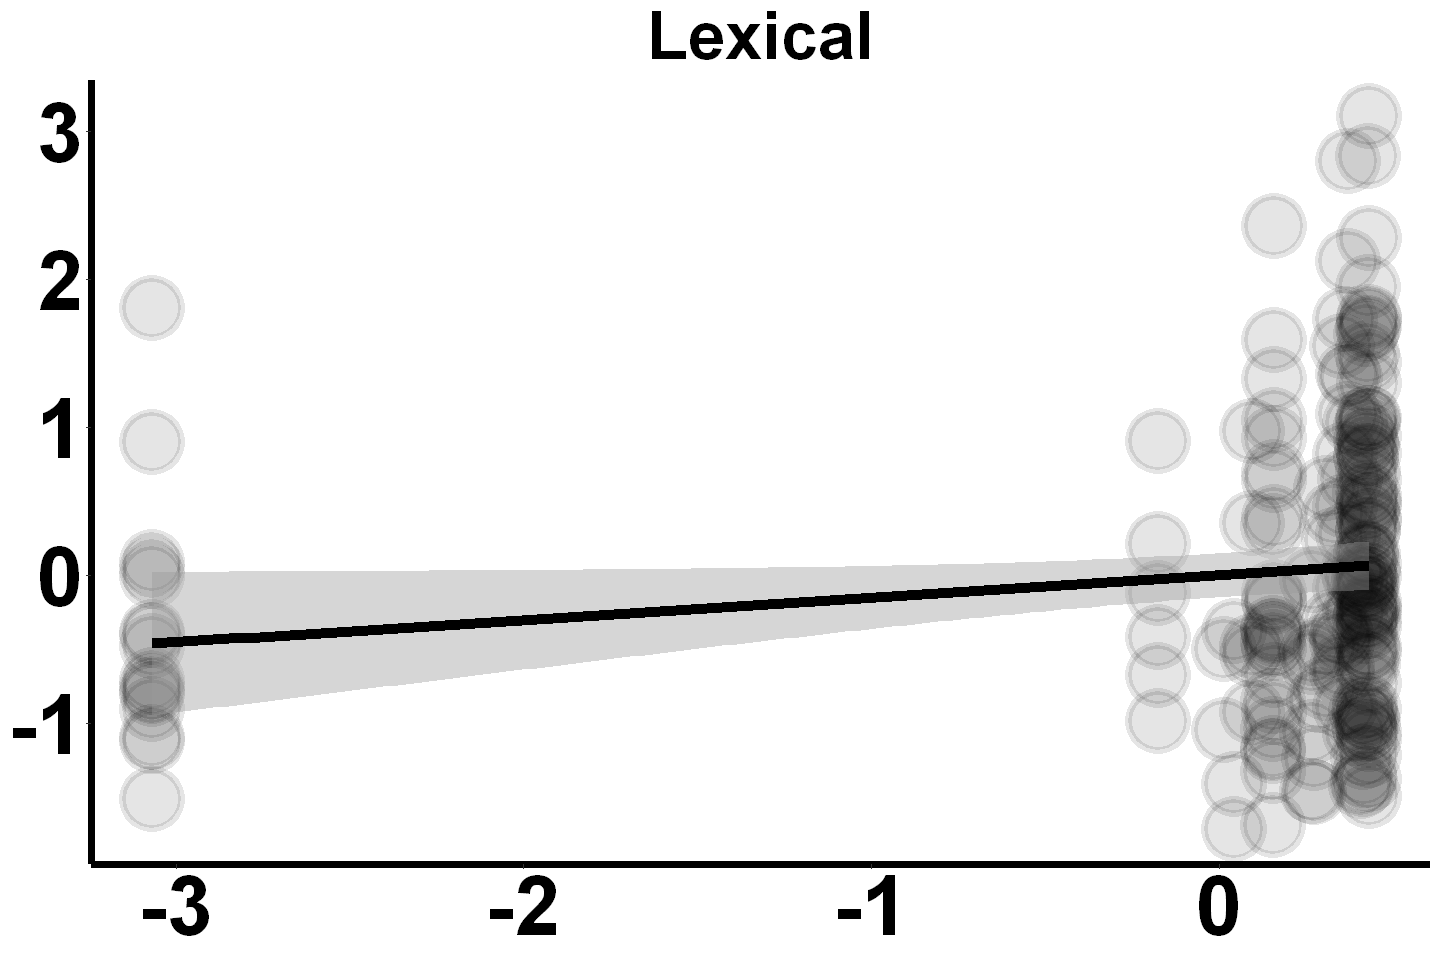

In [39]:
options(repr.plot.width = 12,repr.plot.height = 8)
checksize_resutls %>% filter(pre=='lexical') %>%
ggplot(aes(x=pre_rdm,y=model_rdm))+
geom_point(aes(alpha=pre),size=15,stroke=3)+
geom_smooth(aes(linetype = pre),
            method = 'lm', size=3,formula = y ~ x,color = "black") +

theme_classic() + 
theme(axis.title =element_blank(),
    axis.text.y=element_text(size=50,face='bold',color="black"),
    axis.text.x=element_text(size=50,face='bold',color="black"),
    axis.line.x=element_line(linetype=1,color="black",size=2),
    axis.line.y=element_line(linetype=1,color="black",size=2),
    legend.position = 'none',
    plot.title = element_text(hjust = 0.5,size=40,face='bold'))+
ggtitle('Lexical')

In [53]:
checksize_resutls_regionlabel %>% mutate(region = case_when(
                            region1%in%c('Russia','India','Qatar','Egypt')~'noequality',
                            region2%in%c('Russia','India','Qatar','Egypt')~'noequality',
                            TRUE~'normal')) %>% head()

,model_rdm,pre_rdm,pre,region1,region2,region
,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>
1,-0.008483312,-3.0687637,lexical,UK,USA,normal
2,-0.404273484,-3.0687637,lexical,Australia,USA,normal
3,-0.782689058,-3.0687637,lexical,South,Africa,normal
4,-0.034192874,0.2698478,lexical,Germany,USA,normal
5,2.797059425,0.3726551,lexical,Japan,USA,normal
6,0.554993627,0.4206249,lexical,Israel,USA,normal


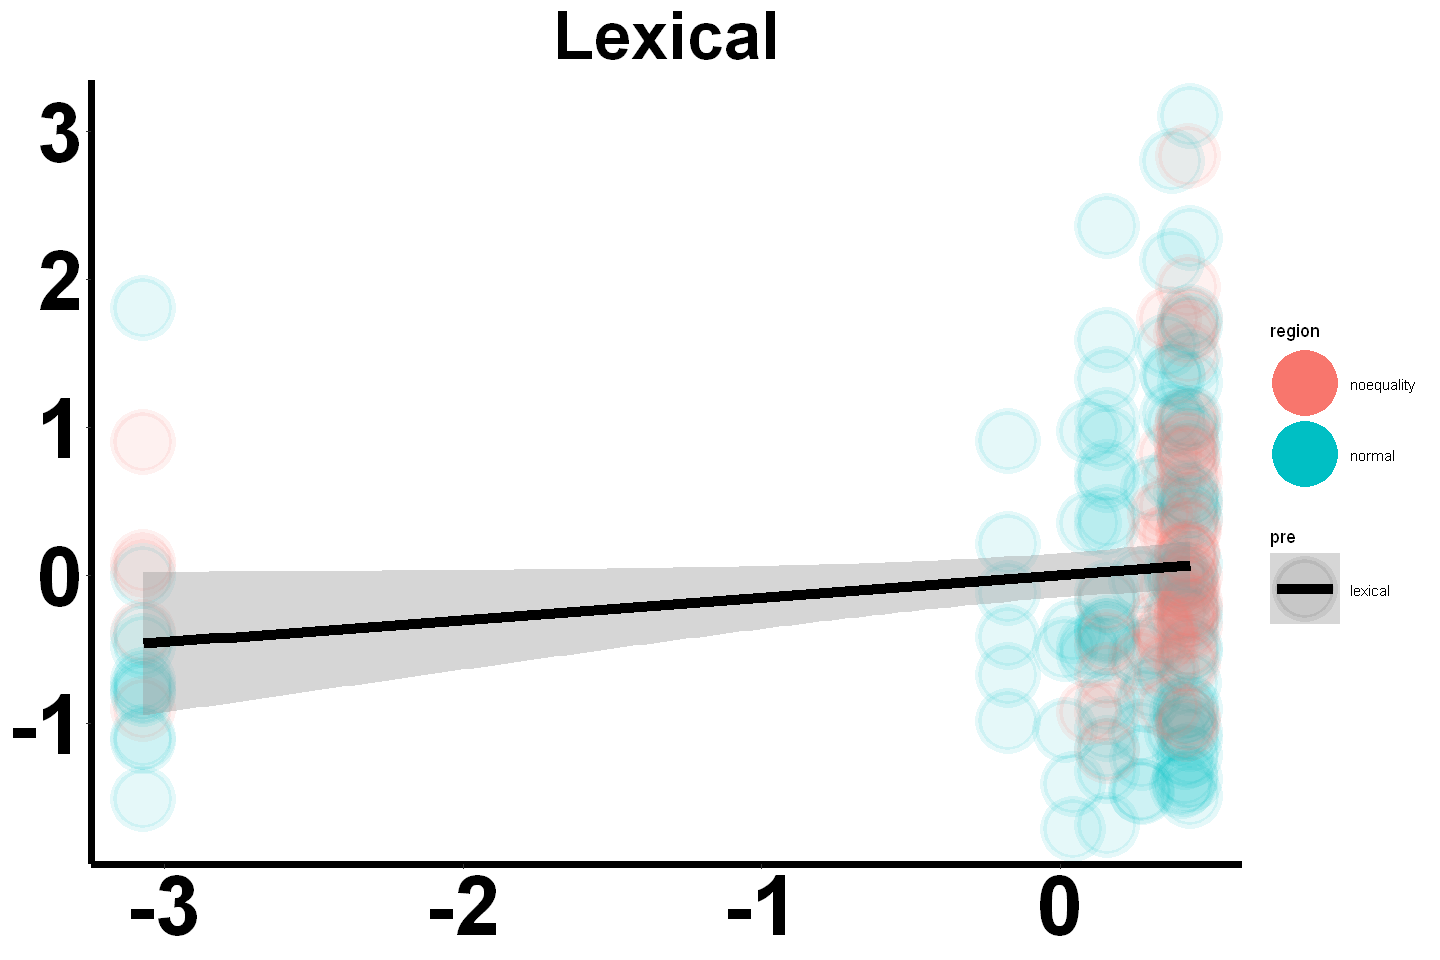

In [59]:
options(repr.plot.width = 12,repr.plot.height = 8)
checksize_resutls_regionlabel %>% mutate(region = case_when(
          region1%in%c('Russia','India','Qatar','Egypt')~'noequality',
          region2%in%c('Russia','India','Qatar','Egypt')~'noequality',
          TRUE~'normal')) %>%
          filter(pre=='lexical') %>%

ggplot(aes(x=pre_rdm,y=model_rdm))+
geom_point(aes(alpha=pre,color=region),size=15,stroke=3)+
geom_smooth(aes(linetype = pre),
            method = 'lm', size=3,formula = y ~ x,color = "black") +

theme_classic() + 
theme(axis.title =element_blank(),
    axis.text.y=element_text(size=50,face='bold',color="black"),
    axis.text.x=element_text(size=50,face='bold',color="black"),
    axis.line.x=element_line(linetype=1,color="black",size=2),
    axis.line.y=element_line(linetype=1,color="black",size=2),
    #legend.position = 'none',
    plot.title = element_text(hjust = 0.5,size=40,face='bold'))+
ggtitle('Lexical')

### modern

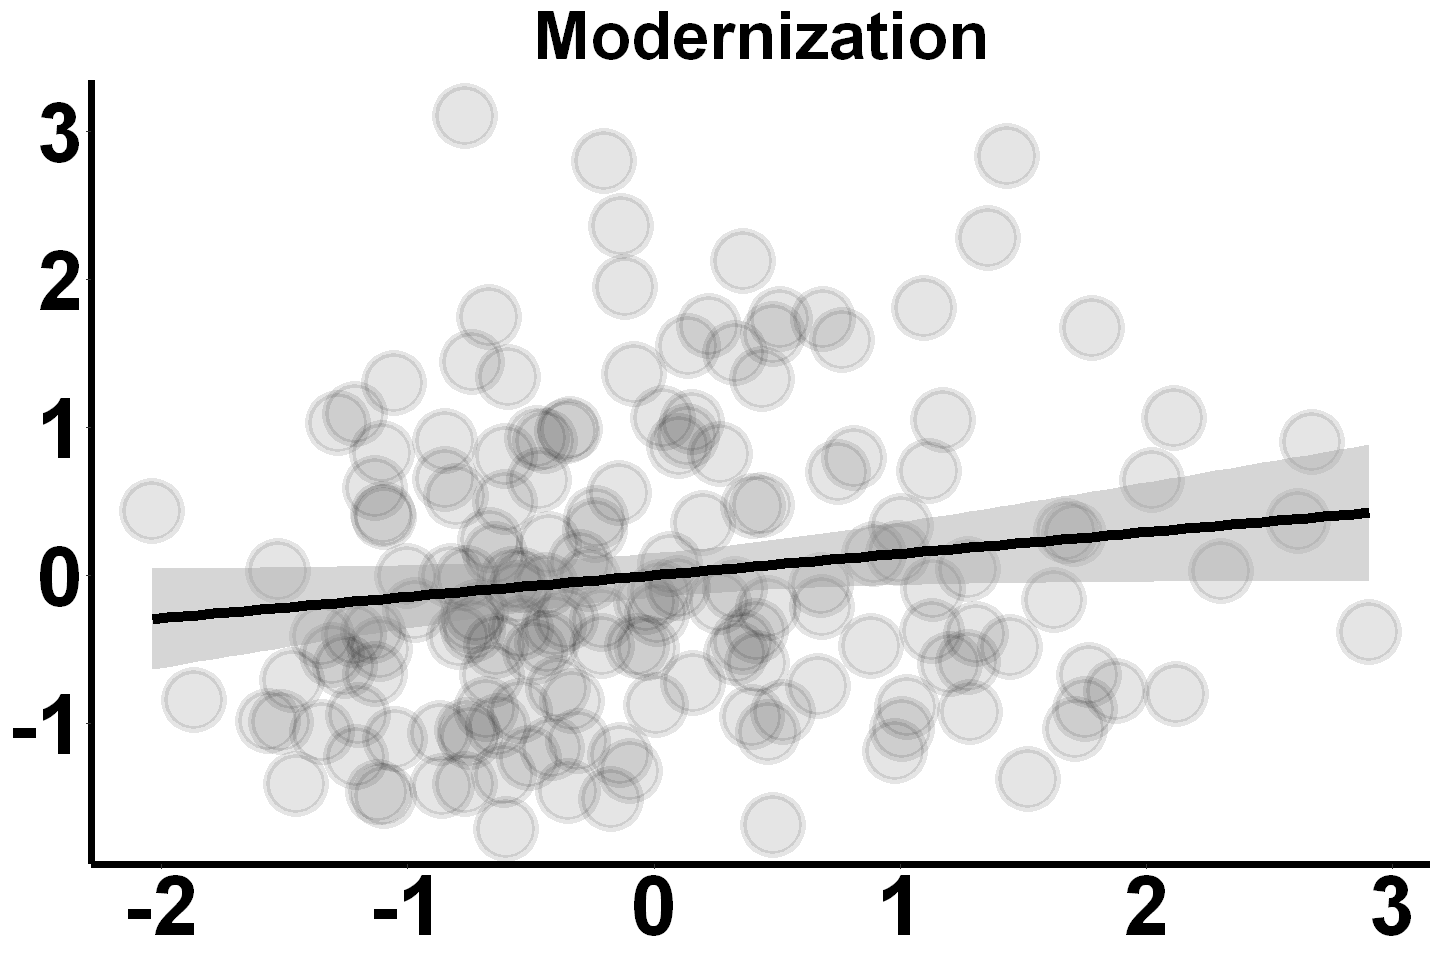

In [42]:
options(repr.plot.width = 12,repr.plot.height = 8)
checksize_resutls %>% filter(pre=='modern') %>%
ggplot(aes(x=pre_rdm,y=model_rdm))+
geom_point(aes(alpha=pre),size=15,stroke=3)+
geom_smooth(aes(linetype = pre),
            method = 'lm', size=3,formula = y ~ x,color = "black") +

theme_classic() + 
theme(axis.title =element_blank(),
    axis.text.y=element_text(size=50,face='bold',color="black"),
    axis.text.x=element_text(size=50,face='bold',color="black"),
    axis.line.x=element_line(linetype=1,color="black",size=2),
    axis.line.y=element_line(linetype=1,color="black",size=2),
    legend.position = 'none',
    plot.title = element_text(hjust = 0.5,size=40,face='bold'))+
ggtitle('Modernization')

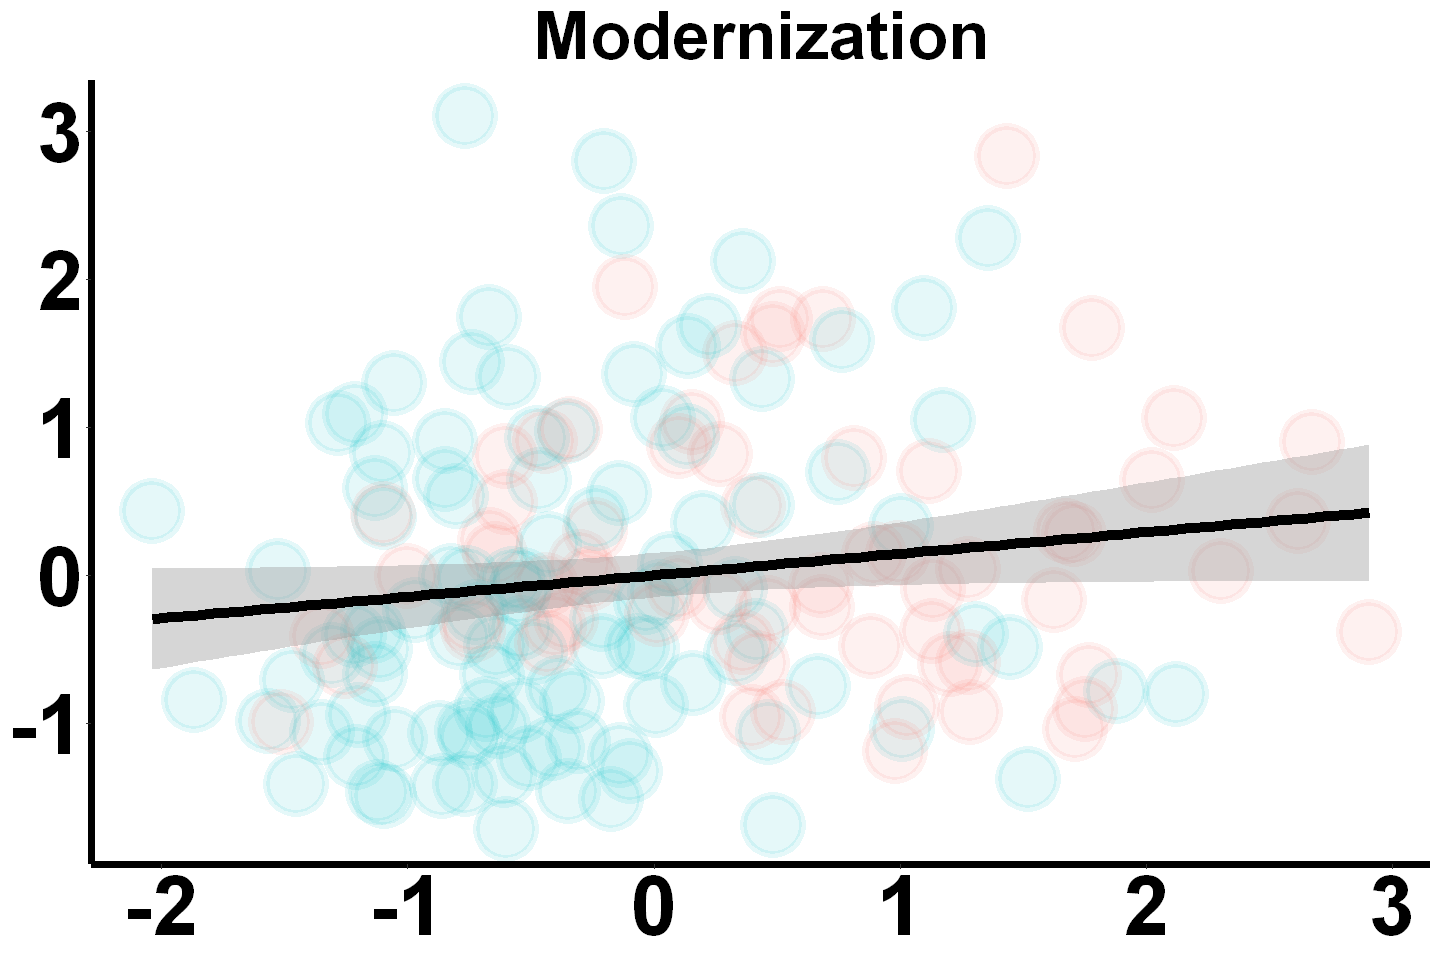

In [61]:
options(repr.plot.width = 12,repr.plot.height = 8)
options(repr.plot.width = 12,repr.plot.height = 8)
checksize_resutls_regionlabel %>% mutate(region = case_when(
          region1%in%c('Russia','India','Qatar','Egypt')~'noequality',
          region2%in%c('Russia','India','Qatar','Egypt')~'noequality',
          TRUE~'normal')) %>%
          filter(pre=='modern') %>%

ggplot(aes(x=pre_rdm,y=model_rdm))+
geom_point(aes(alpha=pre,color=region),size=15,stroke=3)+
geom_smooth(aes(linetype = pre),
            method = 'lm', size=3,formula = y ~ x,color = "black") +

theme_classic() + 
theme(axis.title =element_blank(),
    axis.text.y=element_text(size=50,face='bold',color="black"),
    axis.text.x=element_text(size=50,face='bold',color="black"),
    axis.line.x=element_line(linetype=1,color="black",size=2),
    axis.line.y=element_line(linetype=1,color="black",size=2),
    legend.position = 'none',
    plot.title = element_text(hjust = 0.5,size=40,face='bold'))+
ggtitle('Modernization')